# Lecture II: Convolutional Neural Network

Before we start, I'd like to recommend two very useful pip packages: `tqdm` and `torchsnooper`:
- `tqdm` provide a easy wrapper interface for serial operation such as `for` loop or `while` loop. It display the progress/ETA of the serial operation.
- `torchsnooper` allows you to monitor the code structure and tensor shape within PyTorch code, I find this extremely useful for debugging the network structure.

Let's install these two softwares first:

In [1]:
!pip install tqdm --user
!pip install torchsnooper --user

As usual, let's import some useful module first

In [2]:
# pylint: disable=E1101,R,C
import numpy as np
import os
import argparse
import time
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.autograd import Variable
import gzip
import pickle
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchsnooper
from torch.cuda.amp import autocast 
torch.set_default_tensor_type(torch.FloatTensor)

In this homework, we will train a CNN classifier to classify hand written digits in MNIST dataset.

MNIST stands for Modified National Institute of Standards and Technology database, it contains 70,000 hand written digits from 0 - 9, 60,000 of them are training samples and 10,000 of them are testing samples. MNIST dataset is collected by Prof. Yann LeCun and is oftentime called "the fruitfly of machine learning". You will see it appear as a preliminary test dataset in all kind of Computer Vision papers. The detail of the dataset can be found at: http://yann.lecun.com/exdb/mnist/

Let's first download MNIST dataset:

In [4]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2022-12-02 07:42:28--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-12-02 07:42:28--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [   <=>              ]  33.20M  2.56MB/s    in 14s     

2022-12-02 07:42:43 (2.44 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-images-idx3-ubyte
x MNIST/raw/train-labels-idx1-ubyte.gz
x MNIST/raw/t10k-images-idx3-u


## Part I: Dataset
Before we start building the neural network, it's important to define our dataset object. PyTorch have a neatly organized `Dataset` class that we can use. The class contains several methods:

- `__init__`: Containing the initialization information of the dataset, will be called at the beginning of object initialization.

- `__len__`: The size of the dataset, will be called when we do `len(dataset_object)`

- `__getitem__`: Take in the argument idx and spit out one event per call.

Those 3 are mandatory methods that you have to overwrite to create your dataset. You can self-define other methods if you'd like.

In [3]:
class MNISTDataset(Dataset):

    def __init__(self,plot=True):
        # Load the training and testing dataset
        training_images, training_labels = torch.load(os.path.join(os.getcwd(), "MNIST/processed/training.pt"))
        test_images, test_labels = torch.load(os.path.join(os.getcwd(), "MNIST/processed/test.pt"))
        # Record down the split point between train and test dataset
        self.train_test_split = len(training_labels)
        # Record down the overall dataset size
        self.size = len(training_labels) + len(test_labels)
        
        # Concatenate training and testing dataset
        self.images = torch.cat([training_images, test_images],dim=0)
        self.labels = torch.cat([training_labels, test_labels],dim=0)
        
        if plot:
            # Plot 9 random entries of the dataset
            self.plot_data()
        
    def __len__(self):
        '''
        This function returns the size of overall dataset
        '''
        return self.size


    def __getitem__(self, idx):
        '''
        This function extract a single entry from the dataset at the given index idx
        '''
        return self.images[idx], self.labels[idx]
    
    def get_train_test_split(self):
        '''
        This function get the train test split size of the dataset
        '''
        return self.train_test_split
    
    def plot_data(self):
        '''
        This function plots the images and labels of the MNIST dataset
        '''
        plt.figure(figsize=(12,12))
        sample_index = np.random.randint(low=0,high=self.__len__(), size = 9)
        for i in range(9):
            plt.subplot(3,3, i+1)
            image, label = self.__getitem__(sample_index[i])
            image = image.data.numpy()
            label = label.data.numpy()
            plt.imshow(image)
            plt.title("Handwritten Digit %d"%(label))

We can look at random entries of the MNIST dataset by initializing it:

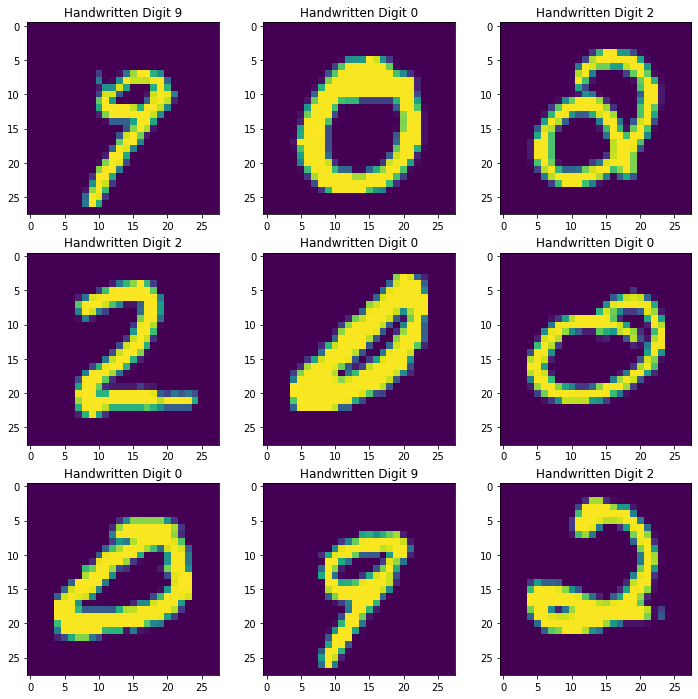

In [4]:
MNISTDataset()

## Part II: Convolutional Neural Network
In this part, we will get some hands-on experience in building a convolutional neural network.

Similar to the PyTorch `Dataset` classs, there is an `nn.Module` class in PyTorch for building arbitrary types of neural networks. The `nn.Module` class contains two methods that have to be overwritten by the user:

- `__init__(self)`: initialization of the neural network class

- `forward(self,x)`: the forward operation of neural network, take in the training/testing input x and output the network output y

Another useful utilities is the `nn.Sequential` method. It allows us to simply stack layers in an python list to form a deep neural network. In the following block, we will build a 2D Convolutional Neural Network using:

- `nn.Conv2d`: https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html#conv2d

- `nn.BatchNorm2d`: https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm2d#torch.nn.BatchNorm2d

- `nn.Linear`: https://pytorch.org/docs/master/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear

- `nn.LeakyReLU`: https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html?highlight=leakyrelu#torch.nn.LeakyReLU

- `nn.MaxPool2d`: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool2d#torch.nn.MaxPool2d

- `nn.Sequential`: https://pytorch.org/docs/master/generated/torch.nn.Sequential.html?highlight=sequential#torch.nn.Sequential

Since the size of MNIST image is relatively small(${28 \times 28}$), you should be careful when using the pooling layers, since each ${2 \times 2}$ pooling layer will reduce the image size to 25%. If you overuse the pooling layer, then the output feature map will be smaller than ${1 \times 1}$, which necessarily produce an error, $\textbf{please do not add any extra pooling layers to the network other than the one I have already defined.}$

Your goal is to build a $\textbf{5 convolutional layer, 5 fully connected layer}$ CNN.

Note that the output of this CNN model should have a size of `[BATCHSIZE,10]`. The 10 outputs of each event represent the relative likelihood of input event being that specific digits.

For each `nn.Conv2d` layers, you need to specify `in_channel`, `out_channel` and `kernel_size`. I will start the first layer, and let you do the rest:

In [5]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        '''
        Initialize the CNN. As mentioned in the lecture, CNN contains 2 parts:
            A convolutional feature extractor
            A fully connected classifier
        '''
        
        self.feature_extrator = nn.Sequential(
            nn.Conv2d(1,5,3),      # in_channel = 1 (one channel per MNIST image), out_channel = 5, kernel = (3,3)
            nn.BatchNorm2d(5),     # BatchNorm2D takes the out_channel of previous Conv2D layers
            torch.nn.LeakyReLU(),  # Activation function
            nn.Conv2d(5,10,3),
            nn.BatchNorm2d(10),
            torch.nn.LeakyReLU(),
            nn.Conv2d(10,15,3),
            nn.BatchNorm2d(15),
            torch.nn.LeakyReLU(),
            nn.Conv2d(15,20,3),
            nn.BatchNorm2d(20),
            torch.nn.LeakyReLU(),
            nn.Conv2d(20,25,3),
            nn.BatchNorm2d(25),
            torch.nn.LeakyReLU(),
            nn.MaxPool2d(2),        # Pooling Layer
            
        )
        
        # Fill in the fully connected classifiers using nn.Linear and nn.LeakyReLU
        self.fc_classifier = nn.Sequential(            
            nn.Linear(2025,512),
            torch.nn.LeakyReLU(),
            nn.Linear(512,400),
            torch.nn.LeakyReLU(),
            nn.Linear(400,200),
            torch.nn.LeakyReLU(),
            nn.Linear(200,50),
            torch.nn.LeakyReLU(),
            nn.Linear(50,10),
            torch.nn.LeakyReLU(),
        )
    #@torchsnooper.snoop()
    def forward(self, x):
        '''
        The forward operation of each training step of the neural network model
        '''
        batch_size = x.size(0)        # Read the input batch size
        
        x = x.unsqueeze(1)            # x.size = (Batch Size, 28, 28) -> (Batch Size, 1, 28, 28), the inserted dimension corresponds to channel dimension (channel = 1)
        x = self.feature_extrator(x)  # Feature extraction
        x = x.view(batch_size, -1)    # Flatten the output feature map into a 1D feature vector
        x = self.fc_classifier(x)     # The size of output x should have a shape of [BATCH_SIZE, 10], where the second dimension corresponds to the probability vector of 10 hand written digits
        return x


After building the CNN module, it's very likely that it won't work, because you haven't adjust the parameters, especially the number of channels in the first `nn.Linear` layer of `self.fc_classifier`. The input of this layer has to be the length of flattened feature map. Otherwise, PyTorch will spit out a size mismatch error.

The size of feature vector can be calculated by hand, what I usually do is to run a quick forward pass with `torchsnooper.snoop()` to look at the size of tensor. that will naturally tell you the size of the feature vector:

In [6]:
#Pull out 1 event from the dataset
test_event, test_label = next(iter(MNISTDataset(plot=False)))
test_event = test_event.unsqueeze(0).float() # (1,28,28) -> (1,1,28,28), inserting 1 more dimensions as batch dim
test_network = CNN()
print(test_network(test_event))

tensor([[ 9.1513e-02, -1.0783e-03, -1.1611e-04, -1.0421e-03,  5.4153e-02,
         -1.0055e-03, -1.0258e-03,  1.3012e-01,  1.9630e-01, -4.6156e-04]],
       grad_fn=<LeakyReluBackward0>)


In this test, you'd like to check for a few things:
- There is no error spit out when running this function
- The `print(test_network(test_event))` line will print out a tensor, as expected
- The output tensor should have a size of (1,10), where 1 correspnd to the batch size (here we feed in only 1 event, so the batch size is 1), the second dimension correspond to the network output for each digit (0-9, 10 digits in total).

After all criteria are satisfied, you will be able to proceed to the next step. $\textbf{Important: Make sure you comment out the `torchsnooper.snoop()` line in front of forward() and rerun the CNN block before you proceed to the training, otherwise you will get a million lines of output from torchsnooper.}$"

## Part III: Training
Again, I'd like to re-emphasize that 𝐌𝐚𝐤𝐞 𝐬𝐮𝐫𝐞 𝐲𝐨𝐮 𝐜𝐨𝐦𝐦𝐞𝐧𝐭 𝐨𝐮𝐭 𝐭𝐡𝐞 𝐭𝐨𝐫𝐜𝐡𝐬𝐧𝐨𝐨𝐩𝐞𝐫.𝐬𝐧𝐨𝐨𝐩() 𝐥𝐢𝐧𝐞 𝐢𝐧 𝐟𝐫𝐨𝐧𝐭 𝐨𝐟 𝐟𝐨𝐫𝐰𝐚𝐫𝐝() 𝐚𝐧𝐝 𝐫𝐞𝐫𝐮𝐧 𝐭𝐡𝐞 𝐂𝐍𝐍 𝐛𝐥𝐨𝐜𝐤 before you dive into this section.

The training of neural network can be done in a simple for-loop. First, let's define a few parameters:

- `NUM_EPOCHS` : One epoch means training through the data set once, so number of epochs means the # of times we loop through the entire dataset.
- `LEARNING_RATE`: As we discussed in lecture I, learning rate is the step with of Gradient Descent algorithm.
- `DEVICE`: The device we'd like to use to train the network. Our model and data need to be fed into the device.
- `BATCH_SIZE`: Size of minibatch in SGD mechanism

In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This says if GPU is available, use GPU, otherwise use CPU
NUM_EPOCHS =20
LEARNING_RATE =1e-2 # 1e-2 is a good learning rate for general purpose
BATCH_SIZE=32

Next, we need to define several important instances for training purpose:
- `classifier`: The neural network model we defined and tested earlier
- `criterion`: The loss function we'd like to train against. Since we'd like to classify each image into class of 0-9 digits, we use `CrossEntropyLoss` as our loss function(https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss)
- `Optimizer`: The optimizer of neural network model. Here we will use the SGD optimizer.

In [8]:
def set_up_classifier():
    classifier = CNN() # Define CNN neural network classifier
    classifier.to(DEVICE)     # Send the classifier to DEVICE as we defined earlier

    print("# of params in model: ", sum(x.numel() for x in classifier.parameters()))

    criterion = torch.nn.CrossEntropyLoss()
    criterion = criterion.to(DEVICE)

    #Define the optimizer
    optimizer = torch.optim.SGD(classifier.parameters(),lr=LEARNING_RATE)
    
    return classifier, criterion, optimizer

The last thing before training is to define a data loader. Data loader takes in a `Dataset()` object, and convert it to a iterator for training purpose. We will split our dataset into `train_loader` and `test_loader`, and only use `train_loader` to train the classifier.

In [9]:
def get_dataloader():
    dataset = MNISTDataset(plot=False)
    #Get the indices of train dataset and test dataset correspondingly, indices [0:train_test_split] is the training dataset, indices [train_test_split, len(dataset)] is the test dataset.
    train_test_split = dataset.get_train_test_split()
    train_indices, val_indices = list(range(train_test_split)), list(range(train_test_split,len(dataset)))

    #Shuffle the two indices list
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    # Define two subset random sampler to sample events according to the training indices
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    # Finally, define the loader by passing in the dataset, batch size and corresponding sampler
    # Note that the number of data in each sub-dataset might not be divisibe by the batch size, so drop_last=True drops the last batch with all the residual events.
    train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
    test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE,sampler=valid_sampler,  drop_last=True)
    
    return train_loader, test_loader


Having all the tools at hand, we can proceed to train our CNN. The training of CNN is done in the following steps:
- Loop through all events in the train_loader
- For each step, convey both image and label to the DEVICE
- Feed image into classifier to produce network outpu
- Feed network output and label into the loss function(criterion), to calculate the loss value
- Back-propagate the loss to update gradient
- Ask the optimizer to optimize for 1 step, then clear the gradient in the network
After each epoch of training, we will also store the training loss and classification accuracy for the next section.

In [10]:
classifier, criterion, optimizer = set_up_classifier()
train_loader, test_loader = get_dataloader()

loss_values = []
accuracy_values = []
y_true = []
y_pred = []

for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        classifier.train() # This line set the neural network to train mode, some layers perform differently in train and test mode.
        
        images = images.to(DEVICE).float()
        labels = labels.to(DEVICE)
        
        #Train the CNN classifier
        outputs  = classifier(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Back-propagate loss to update gradient
        loss.backward()
        
        # Perform gradient descent to update parameters
        optimizer.step()
        
        # reset gradient to 0 on all parameters
        optimizer.zero_grad()

    print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
        epoch+1, NUM_EPOCHS, i+1, len(train_loader),
        loss.item(), end=""),end="")
    loss_values.append(loss.item())
    
    #After every epoch, evaluate the validation accuracy on the test loader
    num_accurate = 0
    num_images = 0
    for images,labels in tqdm(test_loader):

        classifier.eval() # This line set the neural network to evaluation mode, some layers perform differently in train and test mode.
        
        #While validating the network, we do not want it to produce any gradient. This will also save us time/memory
        with torch.no_grad():
            
            # Convey images to device, then feed it to the neural network for network output
            images = images.to(DEVICE).float()
            outputs  = classifier(images)
            
            # Get classification decision by reading out the maximum value on the 10-dimensional vector
            decision = torch.argmax(outputs, dim=-1)
            decision = decision.cpu().data.numpy().flatten() # copy decision to CPU and convert it to a numpy array
            labels = labels.cpu().data.numpy().flatten()
            
            # Update the list of truth value and network predictions in last epoch:
            if epoch == (NUM_EPOCHS-1):
                y_true += list(labels)
                y_pred += list(decision)
            
            #Calculate accuracy by # of correct prediction / total numbers

            num_accurate += np.sum((decision - labels) == 0)
            num_images += len(decision)
    accuracy_values.append(num_accurate/num_images)    

# of params in model:  1342542


1875it [01:05, 28.57it/s]


Epoch [1/20], Iter [1875/1875] Loss: 0.7903

100%|██████████| 312/312 [00:03<00:00, 96.88it/s]
1875it [01:06, 28.27it/s]


Epoch [2/20], Iter [1875/1875] Loss: 0.0236

100%|██████████| 312/312 [00:03<00:00, 92.85it/s]
1875it [01:05, 28.70it/s]


Epoch [3/20], Iter [1875/1875] Loss: 0.0256

100%|██████████| 312/312 [00:03<00:00, 93.69it/s]
1875it [01:08, 27.43it/s]


Epoch [4/20], Iter [1875/1875] Loss: 0.0029

100%|██████████| 312/312 [00:03<00:00, 91.52it/s]
1875it [01:06, 28.23it/s]


Epoch [5/20], Iter [1875/1875] Loss: 0.0300

100%|██████████| 312/312 [00:03<00:00, 96.67it/s]
1875it [01:04, 29.29it/s]


Epoch [6/20], Iter [1875/1875] Loss: 0.0019

100%|██████████| 312/312 [10:49<00:00,  2.08s/it]
1875it [01:45, 17.71it/s]


Epoch [7/20], Iter [1875/1875] Loss: 0.0027

100%|██████████| 312/312 [00:03<00:00, 92.75it/s]
1875it [01:06, 28.07it/s]


Epoch [8/20], Iter [1875/1875] Loss: 0.0041

100%|██████████| 312/312 [00:03<00:00, 93.77it/s]
1875it [01:09, 27.01it/s]


Epoch [9/20], Iter [1875/1875] Loss: 0.0012

100%|██████████| 312/312 [00:03<00:00, 88.20it/s]
1875it [01:08, 27.34it/s]


Epoch [10/20], Iter [1875/1875] Loss: 0.0034

100%|██████████| 312/312 [00:03<00:00, 94.83it/s]
1875it [01:07, 27.93it/s]


Epoch [11/20], Iter [1875/1875] Loss: 0.0013

100%|██████████| 312/312 [00:03<00:00, 94.77it/s]
1875it [01:07, 27.95it/s]


Epoch [12/20], Iter [1875/1875] Loss: 0.1178

100%|██████████| 312/312 [00:03<00:00, 93.35it/s]
1875it [01:06, 28.36it/s]


Epoch [13/20], Iter [1875/1875] Loss: 0.0005

100%|██████████| 312/312 [00:03<00:00, 91.64it/s]
1875it [01:08, 27.24it/s]


Epoch [14/20], Iter [1875/1875] Loss: 0.0008

100%|██████████| 312/312 [00:03<00:00, 93.03it/s]
1875it [01:07, 27.93it/s]


Epoch [15/20], Iter [1875/1875] Loss: 0.0160

100%|██████████| 312/312 [00:03<00:00, 94.71it/s]
1875it [01:07, 27.62it/s]


Epoch [16/20], Iter [1875/1875] Loss: 0.0184

100%|██████████| 312/312 [00:03<00:00, 93.68it/s]
1875it [01:06, 28.23it/s]


Epoch [17/20], Iter [1875/1875] Loss: 0.0006

100%|██████████| 312/312 [00:03<00:00, 92.41it/s]
1875it [01:08, 27.27it/s]


Epoch [18/20], Iter [1875/1875] Loss: 0.0000

100%|██████████| 312/312 [00:03<00:00, 93.52it/s]
1875it [01:07, 27.88it/s]


Epoch [19/20], Iter [1875/1875] Loss: 0.0008

100%|██████████| 312/312 [00:03<00:00, 92.40it/s]
1875it [01:06, 28.39it/s]


Epoch [20/20], Iter [1875/1875] Loss: 0.0005

100%|██████████| 312/312 [00:03<00:00, 90.15it/s]


## Part IV: Evaluate Training Results
After training, we will be able to evaluate our training results.

First, let's plot the learning curve, that is, the loss value with respect to the epochs:

Text(0, 0.5, 'Cross Entropy Loss [a.u.]')

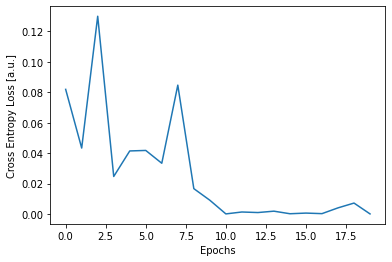

In [22]:
plt.plot(np.arange(NUM_EPOCHS).astype(int), loss_values)
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss [a.u.]")

You should find that the loss drops as you train the network with more and more epochs. If not, what could be the possible cause of it?

Next, let's plot the accuracy curve. That is, the accuracy with respect to epochs:

Text(0, 0.5, 'Classification Accuracy [%]')

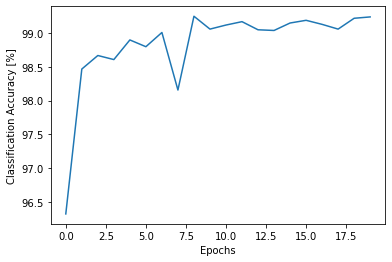

In [23]:
plt.plot(np.arange(NUM_EPOCHS).astype(int), np.array(accuracy_values)*100.0)
plt.xlabel("Epochs")
plt.ylabel("Classification Accuracy [%]")

Lastly, for a multi-class classification problem, it's useful to plot the confusion matrix. We've collected `y_true` and `y_pred` during the training, thus we can directly plot it out using `sklearn.metrics.confusion_matrix`:

Text(0, 0.5, 'Ground Truth')

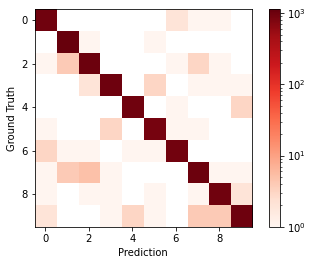

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm,norm=matplotlib.colors.LogNorm(), cmap = "Reds") #Making the z-direction logarithmic scale
plt.colorbar()
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")

$\textbf{Questions}$: How to understand the confusion matrix?

Finally, let's pull out a image, feed it into the trained classifier, and look at the network output. We use a Softmax function to wrap the network output to convert it to probability distribution:

In [1]:
#Pull out 1 event from the dataset
test_event, test_label = MNISTDataset(plot=False)[np.random.randint(len(test_dset))]
plt.imshow(test_event)
test_event = test_event.unsqueeze(0).float() # (1,28,28) -> (1,1,28,28), inserting 1 more dimensions as batch dim
decision = torch.softmax(classifier(test_event),dim=-1).cpu().data.numpy().flatten()
for i in range(len(decision)):
    print("The probability of this image being digit %d is %.1f%%"%(i, decision[i]*100.0))

NameError: name 'MNISTDataset' is not defined

You can run the previous block multiple times to extract classification decisions on different images.

$\textbf{Questions}$: Are these image correctly classified? What kind of hand-written digits is classified with high confidence, and what kind of hand-written digits confuse the machine?